### Numerical method in pricing derivatives 
1.1 Estimating π Using Monte Carlo Simulation
- The concept:

- Square area: 2 × 2 = 4
- Circle: center at (0,0) with x² + y² ≤ 1
Area of circle = πr² = π
- Monte Carlo estimation: π̂ = (4 × counts in circle)/(counts in total)

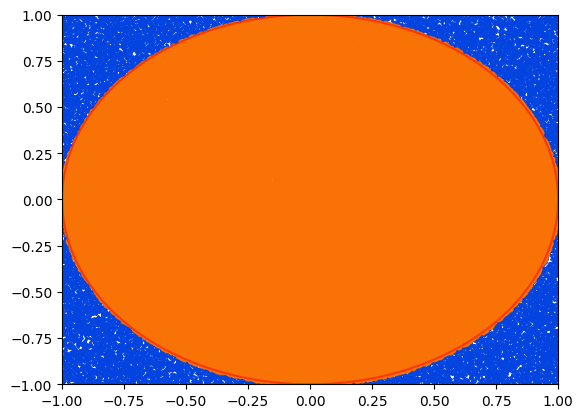

Pi is:
3.14288


In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(5)
n = 100000   # change here for num of estimations 
x = np.random.uniform(-1,1,n)
y = np.random.uniform(-1,1,n)
z = x**2 + y**2

# Create plot
fig, ax = plt.subplots()
dim = 1
plt.xlim(-dim,dim)
plt.ylim(-dim,dim)

# Plot points
plt.scatter(x,y,s=1,c='xkcd:blue')
plt.scatter(x[z<1],y[z<1],s=10,c='xkcd:orange',alpha=0.75)

# Draw circle
a = np.linspace(-1.0, 1.0, 100)
b = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(a,b)
F = X**2 + Y**2 - 1
plt.contour(X,Y,F,[0],colors='r',alpha=0.5)
plt.show()

print('Pi is:')
print(4*sum(z<1)/n)  # Outputs approximately 3.2

### 1.2 Pricing Options with Monte Carlo Simulation
- Step 1: Simulate logarithmic stock price paths


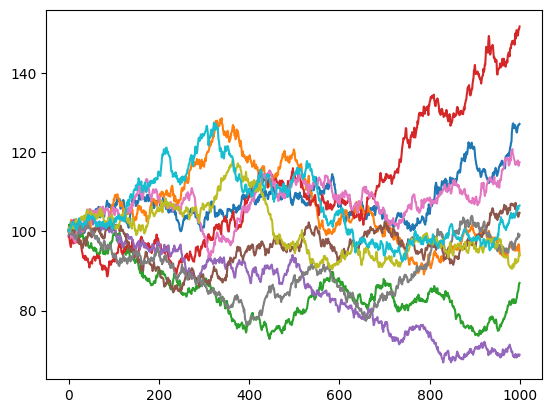

In [2]:
import numpy as np

# Set parameters
np.random.seed(5)

# change sim and steps to see diff result 
nsim = 10
nstep = 1000

T = 1
dt = T/nstep
r = 0.05
sigma = 0.2
S_0 = 100

# Generate random walks
e = np.random.normal(loc=0.0, scale=1.0, size=(nsim,nstep))
S_t = S_0*np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * e).cumprod(axis=1)

# Plot paths
plt.plot(S_t.T)

plt.show()

- Step 2: Compute terminal payoffs and prices for European options


In [3]:
K = 100
S_T = S_t[:,nstep-1]

# Call option
C_T = np.fmax(S_T - K,0)
C_0 = np.exp(-r*T) * np.mean(C_T)
print(f'European call price (Monte Carlo): {round(C_0,2)}')

# Put option
P_T = np.fmax(K - S_T,0)
P_0 = np.exp(-r*T) * np.mean(P_T)
print(f'European put price (Monte Carlo): {round(P_0,2)}')

European call price (Monte Carlo): 10.24
European put price (Monte Carlo): 5.43


- Step 3: BS model comparison ( assumed to be right!! )


In [4]:
from scipy import stats

def BS_call(S, K, r, t, Sigma):
    d1 = (np.log(S/K) + (r + 0.5 * Sigma**2)*t)/(Sigma * np.sqrt(t))
    d2 = d1 - Sigma * np.sqrt(t)
    Call = S * stats.norm.cdf(d1,0.0,1.0) - K * np.exp(-r*t) * stats.norm.cdf(d2,0.0,1.0)
    return Call

def BS_call_delta(S, K, r, t, Sigma):
    d1 = (np.log(S/K) + (r + 0.5 * Sigma**2)*t)/(Sigma * np.sqrt(t))
    delta = stats.norm.cdf(d1,0.0,1.0)
    return delta


def BS_put(S, K, r, t, Sigma):
    d1 = (np.log(S/K) + (r + 0.5 * Sigma**2)*t)/(Sigma * np.sqrt(t))
    d2 = d1 - Sigma * np.sqrt(t)
    Put = K * np.exp(-r*t) * stats.norm.cdf(-d2,0.0,1.0) - S * stats.norm.cdf(-d1,0.0,1.0)
    return Put

print(f'European call price (BSM): {round(BS_call(S_0, K, r, T, sigma),2)}')
print(f'European put price (BSM): {round(BS_put(S_0, K, r, T, sigma),2)}')

European call price (BSM): 10.45
European put price (BSM): 5.57


- Step 4: Estimate Delta using Monte Carlo


In [6]:
h = 0.0001
Sh_0 = S_0 + h
Sh_t = Sh_0*np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * e).cumprod(axis=1)
Sh_T = Sh_t[:,nstep-1]  # Terminal stock prices
Ch_T = np.fmax(Sh_T - K,0)  # Call payoffs at maturity
Ch_0 = np.exp(-r*T) * np.mean(Ch_T)  # Discounted expected payoff
delta_mc = (Ch_0 - C_0)/h   #  Numerical approximation of delta

print('European call delta (MC)')
print(round(delta_mc, 2))

print('European call delta (BSM)') 
print(round(BS_call_delta(S_0, K, r, T, sigma), 2))

European call delta (MC)
0.58
European call delta (BSM)
0.64


### note : 
- This section calculates option Delta using finite differences:

- Uses a small price increment (h) to approximate the derivative
- Simulates new price paths with perturbed initial price (S₀ + h)
- Delta = (C(S₀ + h) - C(S₀))/h


### 1.3 Monte Carlo Puzzle I


In [8]:
prob = 10e-12
ntrial = 1000000
X = np.random.uniform(0,1,ntrial)   # Generate random numbers between 0 and 1
print(np.mean((X < prob)*1))  # Outputs 0.0, but the answer should be : prob = 10⁻¹²

0.0


### note : 
- This demonstrates a limitation of basic Monte Carlo:

- Trying to estimate a very small probability (10⁻¹²)
- Even with 1 million trials, gets 0 as result
- Shows MC is inefficient for rare event simulation
- Need more sophisticated techniques for rare events

This is called the "rare event problem" in Monte Carlo simulation, and it's why more sophisticated techniques (like importance sampling) are needed for estimating very small probabilities.

### 1.4 Monte Carlo Puzzle II


In [12]:
nsim = 100
nstep = 1
T = 5
dt = T/nstep
r = 0.05
sigma = 0.1  # volatility 
S_0 = 100  # Initial stock price

# Generate random shocks and simulate stock prices
e = np.random.normal(loc=0.0, scale=1.0, size=(nsim,nstep)) # Random normal variables
S_t = S_0*np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * e).cumprod(axis=1) # Stock price paths
S_T = S_t[:,nstep-1] # Terminal stock prices

# Calculate present value of expected future price
ES_t = np.exp(-r*T) * np.mean(S_T)
print(f'Present value of expected stock price: {round(ES_t,2)}')

Present value of expected stock price: 99.66


### note : 
- This demonstrates martingale property verification:

- Simulates stock price paths
- Calculates discounted expected future price
- Result ≈ 100.48 vs initial price 100
- Small difference due to simulation error
- Should be exactly equal theoretically

### 1.5 Antithetic Variates


In [18]:
# Import required libraries
import numpy as np
import pandas as pd

# Set random seed
np.random.seed(5)

# Set parameters
nsim = 1000
nstep = 100
T = 1
dt = T/nstep
r = 0.05
sigma = 0.2
S_0 = 100

# Step 1: Generate original " random shocks "
e = np.random.normal(loc=0.0, scale=1.0, size=(nsim,nstep))
print('The empirical average of shocks:')
print(round(np.mean(e),4))

# Step 2: Create antithetic pairs by adding negatives of original shocks
e_av = np.concatenate((e,-e), axis = 0)
print('The empirical average of shocks after the method of antithetic variates:')
print(round(np.mean(e_av),4))

# Step 3: Price options with antithetic variates
K = 100
S_t = S_0*np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * e_av).cumprod(axis=1)
S_T = S_t[:,nstep-1]

# Calculate call option price
C_T = np.fmax(S_T - K,0)
C_0 = np.exp(-r*T) * np.mean(C_T)
print('European call price (Monte Carlo with antithetic variates)')
print(round(C_0,2))

# Calculate put option price
P_T = np.fmax(K - S_T,0)
P_0 = np.exp(-r*T) * np.mean(P_T)
print('European put price (Monte Carlo with antithetic variates)')
print(round(P_0,2))

# Compare with BSM model
print('European call price (BSM)')
print(round(BS_call(S_0, K, r, T, sigma),2))
print('European put price (BSM)')
print(round(BS_put(S_0, K, r, T, sigma),2))

The empirical average of shocks:
0.0038
The empirical average of shocks after the method of antithetic variates:
0.0
European call price (Monte Carlo with antithetic variates)
10.6
European put price (Monte Carlo with antithetic variates)
5.68
European call price (BSM)
10.45
European put price (BSM)
5.57
